![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

**About**

This notebook creates two heatmaps based on the number of updates and size of updates released by each municipality. 

The methodology for determining update size is as follows:

1.   For each municipality, determine the content length - the character count - of all crawls.
2.   For each crawl calculate the difference in content length compared to the previous time it was crawled.
3.   For each url calculate the average of the differences over a month timeframe.
4.   For each municipality calculate the average of the monthly url averages. 

The way the *number of updates* is determined is very similar. The number of crawls for each municipality are determined. The difference in content length compared to a previous crawl is calculated. If there is a difference it is considered an update. The updates are then summed over a period of a month.

**Limitations**

*   The update size heat map is quite large. Making it smaller is difficult because 
it becomes hard to read the numbers.

*   The assumption is that the character count of each crawl is indicative of information related to covid but this is not necessarily true. Structural - html code - changes also count as updates. This means that if a page has any kind of redesign it is considered an update and its update size is captured. 

*   Rewording of existing information, while presenting nothing new, is also considered an update. 

*   There are likely other municipality urls that contain covid information that have not been analyzed.

*   The first crawl of a url is only partially counted in the analysis. Let's look at *https://www.grimsby.ca/en/covid-19.aspx* as an illustrative example. In the first table we have the length of each crawl by character count. In the second table we have the change in size from one crawl to the next. Notice that 2020-04-17 is not present in Table 2, but was still used to calculate the size for 2020-04-24. If we included 2020-04-17 in table 2, the update size would be 23167 and this would change the results quite a bit. In essence the first crawl is not counted as an update. 

```
  https://www.grimsby.ca/en/covid-19.aspx

  Table 1. Crawl lengths.

  crawl_date  length
  2020-04-17  23167 
  2020-04-24  23562 
  2020-05-04  24198 
  ...

  Table 2. Update size.

  2020-04-24    395.0  
  2020-05-04    636.0  
  2020-05-15    1091.0
  ...
```

However, for certain urls I have decided to include the first crawl as an update. The rational is that these urls were created specifically as updates. They are the following: 

```
"https://lincoln.ca/news/2021/01/media-release-town-lincoln-responds-new-covid-19-guidelines-due-ontario-state-emergency",
"https://www.grimsby.ca/en/news/proof-of-vaccination-required-at-select-grimsby-facilities-beginning-sept-22.aspx",
"https://www.westlincoln.ca/en/news/update-28-west-lincoln-response-to-covid-19-appointment-system-at-the-wl-community-centre.aspx",
"https://www.westlincoln.ca/en/news/update-39-response-to-covid-19-west-lincoln-is-staying-the-course.aspx",
"https://www.westlincoln.ca/en/news/update-40-response-to-covid-19-ontario-strengthens-enforcement-of-stay-at-home-order.aspx",
"https://www.westlincoln.ca/en/news/update-43-west-lincoln-response-to-covid-19-township-re-opens-appointment-only-starting-june-14-21.aspx",
"https://www.westlincoln.ca/en/news/update-17-west-lincoln-response-to-covid-19-phase-one-of-reopening.aspx",
"https://www.westlincoln.ca/en/news/update-15-west-lincoln-response-to-covid-19-township-facilities-closed-until-may-31st.aspx",
"https://www.westlincoln.ca/en/news/update-18-west-lincoln-response-to-covid-19-recovery-in-a-phased-approach.aspx",
"https://www.westlincoln.ca/en/news/update-23-west-lincoln-response-to-covid-19-playgrounds-start-to-re-open-july-24th-2020.aspx",
"https://www.westlincoln.ca/en/news/update-38-response-to-covid-19-ontario-government-puts-emergency-brake-on-the-entire-province.aspx"
```





In [ ]:
!pip install matplotlib==3.5.1
import pandas as pd
import re
import requests
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from google.colab import data_table
data_table.enable_dataframe_formatter()

pd.set_option('display.max_colwidth', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/municipal_data.csv.gz")
  !gunzip -f municipal_data.csv.gz
  archive_data = pd.read_csv("municipal_data.csv")
  archive_data.drop(columns=['Unnamed: 0', 'index', 'v_pos','v_neg','v_neu','v_comp', 'mime_type_web_server', 'mime_type_tika', 'language'], inplace=True)
  archive_data = archive_data[archive_data.content.notna()]
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data


In [ ]:
#Code taken from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    

    try:
      cmap_type = kwargs.pop('cmap')
    except KeyError:
      cmap_type = 'viridis'

    cmap = matplotlib.cm.get_cmap(cmap_type).copy()
    cmap.set_over('red')
    cmap.set_under('purple')
    im = ax.imshow(data, cmap=cmap, **kwargs)
    
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
urls_of_interest = set([
"https://www.niagararegion.ca/health/covid-19/default.aspx",
"https://www.niagararegion.ca/health/covid-19/protect-yourself.aspx",
"https://www.niagararegion.ca/health/covid-19/employee-information.aspx",
"https://www.niagararegion.ca/health/covid-19/municipal-bills.aspx",
"https://www.niagararegion.ca/health/covid-19/testing.aspx",
"https://www.niagararegion.ca/health/covid-19/symptoms.aspx",
"https://www.niagararegion.ca/health/covid-19/resources.aspx",
"https://www.niagararegion.ca/health/covid-19/self-isolation.aspx",
"https://www.niagararegion.ca/health/covid-19/social-support.aspx",
"https://www.notl.com/COVID-19/",
"https://www.stcatharines.ca/en/livein/covid-19.asp",
"https://niagarafalls.ca/covid19",
"https://niagarafalls.ca/",
"https://lincoln.ca/coronavirus-pandemic",
"https://lincoln.ca/news/2021/01/media-release-town-lincoln-responds-new-covid-19-guidelines-due-ontario-state-emergency",
"https://www.forterie.ca/pages/COVID19News",
"https://www.grimsby.ca/en/covid-19.aspx",
"https://www.grimsby.ca/en/doing-business/covid-19-business-support.aspx",
"https://www.grimsby.ca/en/news/proof-of-vaccination-required-at-select-grimsby-facilities-beginning-sept-22.aspx",
"http://portcolborne.ca/page/covid-19",
"https://www.portcolborne.ca/en/living-here/covid-19.aspx",
"https://www.thorold.ca/en/city-hall/coronavirus-covid-19.aspx",
"https://www.thorold.ca/en/city-hall/city-of-thorold-functions-during-covid-19-pandemic.aspx",
"https://www.welland.ca/hottopics/COVID-19.asp",
"https://www.westlincoln.ca/Modules/News/en",
"https://www.westlincoln.ca/en/news/update-28-west-lincoln-response-to-covid-19-appointment-system-at-the-wl-community-centre.aspx",
"https://www.westlincoln.ca/en/news/update-39-response-to-covid-19-west-lincoln-is-staying-the-course.aspx",
"https://www.westlincoln.ca/en/news/update-40-response-to-covid-19-ontario-strengthens-enforcement-of-stay-at-home-order.aspx",
"https://www.westlincoln.ca/en/news/update-43-west-lincoln-response-to-covid-19-township-re-opens-appointment-only-starting-june-14-21.aspx",
"https://www.westlincoln.ca/en/news/update-17-west-lincoln-response-to-covid-19-phase-one-of-reopening.aspx",
"https://www.westlincoln.ca/en/news/update-15-west-lincoln-response-to-covid-19-township-facilities-closed-until-may-31st.aspx",
"https://www.westlincoln.ca/en/news/update-18-west-lincoln-response-to-covid-19-recovery-in-a-phased-approach.aspx",
"https://www.westlincoln.ca/en/news/update-23-west-lincoln-response-to-covid-19-playgrounds-start-to-re-open-july-24th-2020.aspx",
"https://www.westlincoln.ca/en/news/update-38-response-to-covid-19-ontario-government-puts-emergency-brake-on-the-entire-province.aspx",
"https://www.wainfleet.ca/Modules/News/en",
"https://www.wainfleet.ca/en/town-hall/covid-19.aspx",
"https://www.pelham.ca/en/living-here/covid-19.aspx",
"https://www.pelham.ca/en/living-here/covid-19-pelham.aspx"])

domains = [
"westlincoln.ca",
"thorold.ca",
"forterie.ca",
"welland.ca",
"niagararegion.ca",
"notl.com",
"wainfleet.ca",
"portcolborne.ca",
"grimsby.ca",
"lincoln.ca",
"pelham.ca",
"niagarafalls.ca",
"stcatharines.ca"]


In [ ]:
#Retrieve data
data = get_muni_data()
filtered = data[data.url.isin(urls_of_interest)]

Download progress of municipal_data.csv.gz 51339264/51335494: 100%

In [ ]:
#Create indexes
tuples = []
for d in domains:
  domain_urls = set(filtered[filtered.domain==d].url)
  wanted_urls = domain_urls & urls_of_interest
  tuples.extend(itertools.product([d], wanted_urls))

url_index = pd.MultiIndex.from_tuples(tuples)
date_index = pd.Index(sorted(set(filtered.crawl_date)))

In [ ]:
#Create table containing update size deltas
delta_table = pd.DataFrame(index=date_index, columns=url_index)

#Treat the first crawl of the following urls as an update
special_urls = ["https://lincoln.ca/news/2021/01/media-release-town-lincoln-responds-new-covid-19-guidelines-due-ontario-state-emergency",
"https://www.grimsby.ca/en/news/proof-of-vaccination-required-at-select-grimsby-facilities-beginning-sept-22.aspx",
"https://www.westlincoln.ca/en/news/update-28-west-lincoln-response-to-covid-19-appointment-system-at-the-wl-community-centre.aspx",
"https://www.westlincoln.ca/en/news/update-39-response-to-covid-19-west-lincoln-is-staying-the-course.aspx",
"https://www.westlincoln.ca/en/news/update-40-response-to-covid-19-ontario-strengthens-enforcement-of-stay-at-home-order.aspx",
"https://www.westlincoln.ca/en/news/update-43-west-lincoln-response-to-covid-19-township-re-opens-appointment-only-starting-june-14-21.aspx",
"https://www.westlincoln.ca/en/news/update-17-west-lincoln-response-to-covid-19-phase-one-of-reopening.aspx",
"https://www.westlincoln.ca/en/news/update-15-west-lincoln-response-to-covid-19-township-facilities-closed-until-may-31st.aspx",
"https://www.westlincoln.ca/en/news/update-18-west-lincoln-response-to-covid-19-recovery-in-a-phased-approach.aspx",
"https://www.westlincoln.ca/en/news/update-23-west-lincoln-response-to-covid-19-playgrounds-start-to-re-open-july-24th-2020.aspx",
"https://www.westlincoln.ca/en/news/update-38-response-to-covid-19-ontario-government-puts-emergency-brake-on-the-entire-province.aspx",]

for url in urls_of_interest:
  url_diff = filtered[filtered.url == url].loc[:,['crawl_date','length']]
  url_diff = url_diff.drop_duplicates(['crawl_date']).set_index('crawl_date').sort_index()
  if url in special_urls:
    
    #Save the first crawl's length that would otherwise disappear when we diff()
    first_crawl_length = url_diff.iloc[0].length
    url_diff = url_diff.diff()

    #Assign the first crawl's length back into the url_diff dataframe
    url_diff.iloc[0].length = first_crawl_length
  else:
    url_diff = url_diff.diff()
  delta_table.loc[:,(slice(None),url)] = url_diff.length


In [ ]:
# url = "https://www.grimsby.ca/en/covid-19.aspx"
# print(filtered[filtered.url == url].loc[:,['crawl_date','length']])
# t = delta_table.loc[:,("grimsby.ca", url)]
# print(t[~t.isna()])

In [ ]:
#1. Calculate mean of deltas over a period of 1 month for each url
#2. Calculate mean of all url means for each domain
crawl_means = delta_table.groupby(pd.Grouper(freq='1M')).mean()
crawl_means = crawl_means.transpose().groupby(pd.Grouper(level=0)).mean()
crawl_means

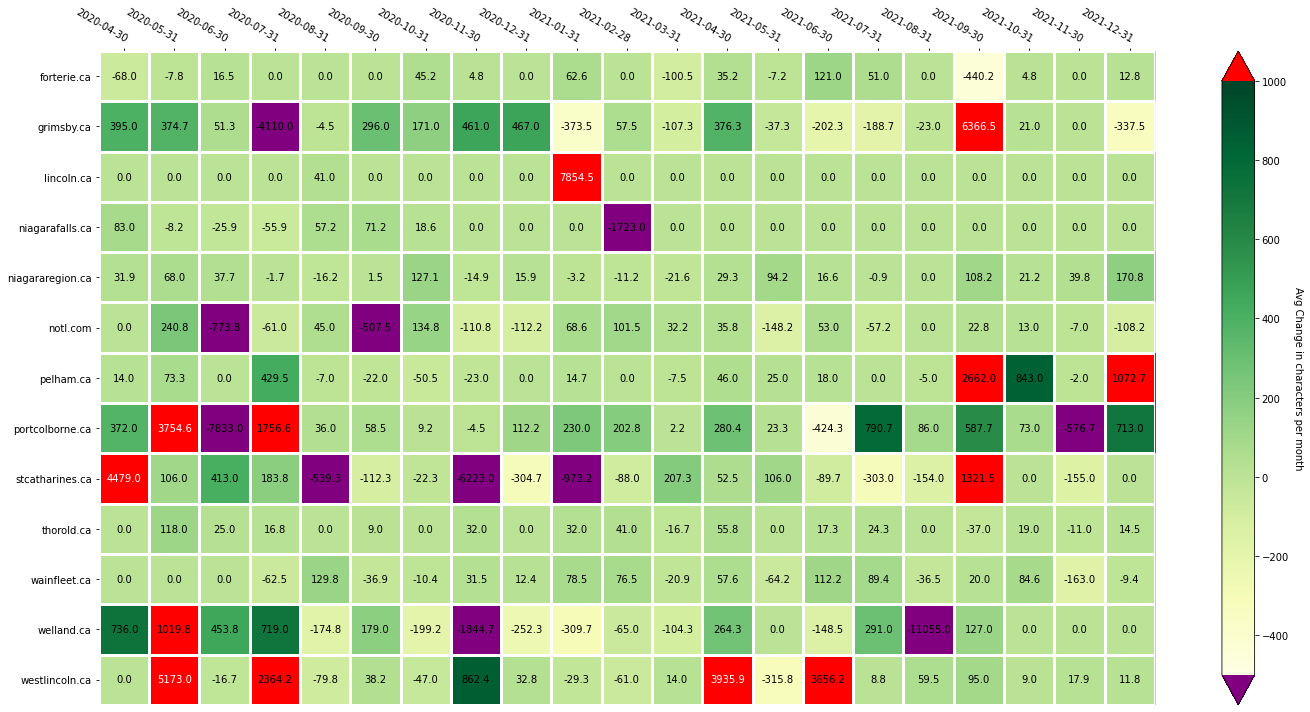

In [ ]:
tdf = crawl_means.copy()
tdf[tdf.isna()] = 0

fig, ax = plt.subplots(figsize=(20,10))

column_labels = list(map(lambda ts: ts.strftime('%Y-%m-%d'), tdf.columns))
im, cbar = heatmap(tdf, tdf.index, column_labels, ax=ax, cmap='YlGn',
                    cbar_kw={'extend':'both'}, cbarlabel="Avg Change in characters per month", vmin=-500, vmax=1000)
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

**Update frequency**

In [ ]:
# 0.0 values in the delta_table mean that no updates occurred
# set these values to NaNs so the groupby count() aggregator ignores them
dt_cp = delta_table.copy()
dt_cp[dt_cp == 0] = np.nan

update_table = dt_cp.groupby(pd.Grouper(freq='1M')).count().transpose().groupby(level=0).sum()
update_table

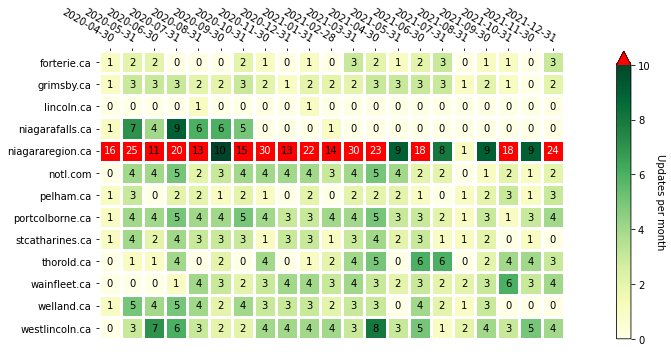

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

column_labels = list(map(lambda ts: ts.strftime('%Y-%m-%d'), update_table.columns))
im, cbar = heatmap(update_table, update_table.index, column_labels, ax=ax, cmap='YlGn',
                    cbar_kw={'extend':'max'}, cbarlabel="Updates per month", vmin=0, vmax=10)
texts = annotate_heatmap(im, valfmt="{x}", threshold=15)

fig.tight_layout()
plt.show()